In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11cd5cfd0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
for row in session.query(Measurement.prcp, Measurement.date).limit(10).all():
    print(row)

(0.08, '2010-01-01')
(0.0, '2010-01-02')
(0.0, '2010-01-03')
(0.0, '2010-01-04')
(None, '2010-01-06')
(0.06, '2010-01-07')
(0.0, '2010-01-08')
(0.0, '2010-01-09')
(0.0, '2010-01-10')
(0.01, '2010-01-11')


In [12]:
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11cdf5ef0>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [31]:
last_date_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = last_date_point.date.split('-')[0]
last_month = last_date_point.date.split('-')[1]
last_date = last_date_point.date.split('-')[2]
print("Last date of dataset")
print(last_date_point, last_year, last_month, last_date)

Last date of dataset
('2017-08-23',) 2017 08 23


In [15]:
year_ago = dt.date(int(last_year),int(last_month), int(last_date)) - dt.timedelta(days=365)
str_year_ago = year_ago.strftime("%Y-%m-%d")
str_year_ago

'2016-08-23'

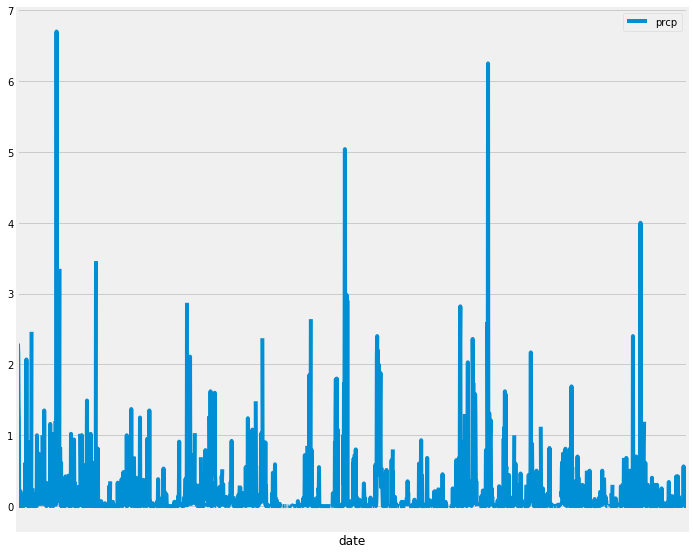

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_year = last_date_point.date.split('-')[0]
last_month = last_date_point.date.split('-')[1]
last_date = last_date_point.date.split('-')[2]

year_ago = dt.date(int(last_year),int(last_month), int(last_date)) - dt.timedelta(days=365)
str_year_ago = year_ago.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
query_result = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > str_year_ago).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.read_sql_query(query_result, session.bind)
prcp_index_by_date = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_sort_by_date = prcp_index_by_date.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_sort_by_date.plot(figsize=(10,8))
plt.tight_layout()
plt.xticks([])
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_index_by_date.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [33]:
# Design a query to show how many stations are available in this dataset?
print("Total Number of stations")
session.query(func.count(Measurement.station)).all()

Total Number of stations


[(19550)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())
most_active = most_active_station.first()[0]
print("List the stations and the counts")
print(most_active_station.all())
print("--------------------------------------------------")
print(f"The most active station is {most_active}")

List the stations and the counts
[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]
--------------------------------------------------
The most active station is USC00519281


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()

print(f"The lowest temperature recorded: {temp[0][0]}")
print(f"The highest temperature recorded: {temp[0][1]}")
print(f"Average temperature: {temp[0][2]}")

The lowest temperature recorded: 54.0
The highest temperature recorded: 85.0
Average temperature: 71.66378066378067


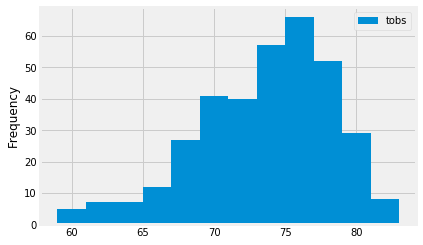

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = temp[0][1]

#session.query(Measurement.tobs, Measurement.date).filter(Measurement.station == most_active)

query_temp = session.query(Measurement.tobs,Measurement.station,Measurement.date).\
    filter(Measurement.date > str_year_ago).\
    filter(Measurement.station == most_active).statement
#qeury_temp
temp_df = pd.read_sql_query(query_temp, session.bind)
#temp_df
temp_df.plot.hist(bins=12)
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.date >= "2016-01-01").all()

[(56.0, 87.0, 74.14409066378845)]

## Optional Challenge Assignment

In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
